# Keyword spotting pre-trained model
This notebook designs a pipeline for spotting the keywords "yes" and "no". Note: the model isn't as accurate as 'state-of-the-art' as it must be small enough to fit on an embedded device.

In [103]:
import os
import pathlib

import tensorflow as tf
import tensorflow_io as tfio
import librosa
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pickle

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

Eager: True


## Import speech commands dataset
This dataset contains over 105,000 WAV audio files of people saying thirty different words. A portion of the dataset will be used to train the model.

In [51]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin='http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip',
        extract=True,
        cache_dir='.', cache_subdir='data')

Eager: True


Check the dataset.

In [52]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['right' 'go' 'no' 'left' 'stop' 'up' 'down' 'yes']
Eager: True


Extract audio and shuffle.

In [53]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:', 
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/right/214ccb20_nohash_0.wav', shape=(), dtype=string)
Eager: True


## Create training, validation and test datasets
Uses an 80:10:10 ratio.

In [54]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400+800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))
print("Eager:", tf.executing_eagerly())

Training set size 6400
Validation set size 800
Test set size 800
Eager: True


## Read audio files and associated labels
We need to convert a WAV-encoded binary audio file to a numerical tensor. `tf.audio.decode_wav` will normalize the values to the range [-1.0, 1.0]. Below is a series of utility functions for performing this conversion along with extracting the associated label.

In [69]:
def decode_audio(audio_binary):
    """Convert binary to normalized tensor."""
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    """Get the label associated with the audio file."""
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

def get_waveform_and_label(file_path):
    """Get a tuple of audio binary and labels."""
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

## Create and preprocess datasets
As previously shown we need to convert the waveforms to Mel Scale Spectrograms.

In [135]:
def get_mel_spectrogram(audio):
    """Get Mel Scale Spectrogram image from waveform."""
    # Pad for files with less than 16000 samples.
    audio = audio.numpy()
    np.pad(audio, (16000,), 'constant', constant_values=0)
    
    mel_spectrogram = librosa.feature.melspectrogram(audio,
                                                     sr=16000,
                                                     n_fft=2048,
                                                     hop_length=64,
                                                     n_mels=128)
    mfcc = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mfcc

def get_spectrogram_and_label_id(audio, label):
    """Preprocess audio sample and label."""
    mel_spectrogram = get_mel_spectrogram(audio)
    mel_spectrogram = tf.expand_dims(mel_spectrogram, -1)
    label_id = tf.argmax(label == commands)
    return mel_spectrogram, label_id

def preprocess_dataset(files):
    """Create dataset from provided files."""
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, 
                             num_parallel_calls=tf.data.AUTOTUNE)
    # Trick to force eager execution of function.
    # Allows numpy code to be executed. This is likely
    # not a good way to do it.
    py_func = lambda x, y: tf.py_function(get_spectrogram_and_label_id, 
                                       [x, y], 
                                       [tf.float32, tf.int64])
    output_ds = output_ds.map(py_func, 
                              num_parallel_calls=tf.data.AUTOTUNE)
    return output_ds

train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

## Show sample of data

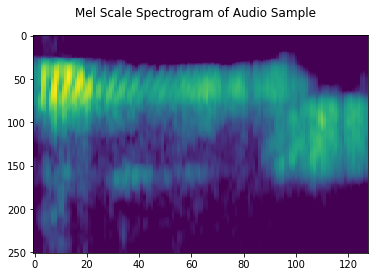

In [137]:
for mfcc, label in train_ds.take(3):
    mfcc = mfcc.numpy()
    plt.imshow(np.swapaxes(mfcc, 0, 1),
               interpolation='nearest',
               cmap=cm.viridis,
               origin='lower',
               aspect='auto')
    plt.suptitle('Mel Scale Spectrogram of Audio Sample')
    plt.gca().invert_yaxis()